<a href="https://colab.research.google.com/github/abhiyantaabhishek/COVID_19_Detection/blob/master/COVID_19_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
!git clone https://github.com/abhiyantaabhishek/COVID_19_Detection
%cd COVID_19_Detection

Cloning into 'COVID_19_Detection'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 759 (delta 2), reused 0 (delta 0), pack-reused 750
Receiving objects: 100% (759/759), 85.65 MiB | 11.82 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [8]:

CT_COVID = ['CT_COVID/'+f for f in  os.listdir('CT_COVID')]
CT_NonCOVID = ['CT_NonCOVID/'+f for f in  os.listdir('CT_NonCOVID')]
CT_COVID_label =  [1]*len(CT_COVID)
CT_NonCOVID_label = [0]*len(CT_NonCOVID)
CT_COVID = np.array(CT_COVID)
CT_NonCOVID = np.array(CT_NonCOVID)
CT_COVID_label = np.array(CT_COVID_label)
CT_NonCOVID_label = np.array(CT_NonCOVID_label)
data_x = np.concatenate([CT_COVID,CT_NonCOVID])
data_y = np.concatenate([CT_COVID_label,CT_NonCOVID_label])

In [9]:
index = np.array(list(range(len(data_x))))
np.random.shuffle(index)
train_x  = data_x[:int(len(index)*0.6)]
valid_x = data_x[int(len(index)*0.6) : int(len(index)*0.6) + int(len(index)*0.2)]
test_x = data_x[ int(len(index)*0.6) + int(len(index)*0.2) : int(len(index)*0.6) + 2*int(len(index)*0.2)]

train_y  = data_y[:int(len(index)*0.6)]
valid_y = data_y[int(len(index)*0.6) : int(len(index)*0.6) + int(len(index)*0.2)]
test_y = data_y[ int(len(index)*0.6) + int(len(index)*0.2) : int(len(index)*0.6) + 2*int(len(index)*0.2)]

In [49]:
from PIL import Image
data_train_x = []
for f in train_x:
  image = Image.open(f).convert('RGB')
  image = np.array(image)
  assert((image[:,:,0] == image[:,:,2]).any())
  assert((image[:,:,0] == image[:,:,1]).any())
  data_train_x.append(image)
data_val_x = []
for f in valid_x:
  image = Image.open(f).convert('RGB')
  image = np.array(image)
  assert((image[:,:,0] == image[:,:,2]).any())
  assert((image[:,:,0] == image[:,:,1]).any())
  data_val_x.append(image)
data_test_x = []
for f in test_x:
  image = Image.open(f).convert('RGB')
  image = np.array(image)
  assert((image[:,:,0] == image[:,:,2]).any())
  assert((image[:,:,0] == image[:,:,1]).any())
  data_test_x.append(image)
data_train_x = np.array(data_train_x)
data_val_x = np.array(data_val_x)
data_test_x = np.array(data_test_x)

In [51]:
data_train_x[0].shape

(242, 384, 3)

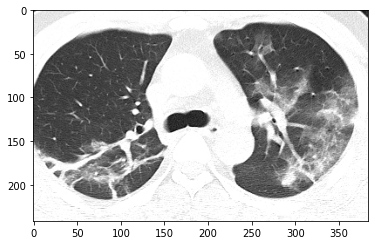

In [46]:
plt.imshow(image[:,:,0:3])

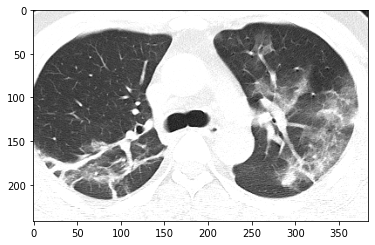

In [44]:
plt.imshow(image[:,:,0],cmap='gray')

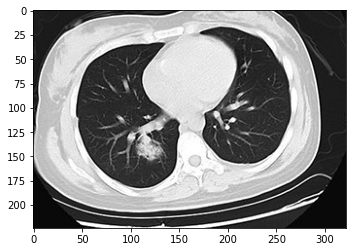

In [45]:
plt.imshow(img[:,:,0:4])

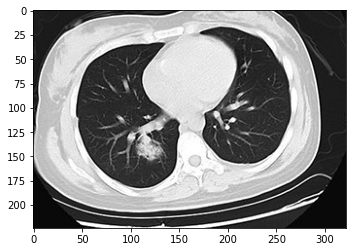

In [23]:
plt.imshow(img[:,:,0:3])

In [28]:
(img[:,:,3:4] == 1).any()

True